In [1]:
# Fernando Martinez

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install pytorch-pretrained-bert

In [2]:
import math
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
import torch

def lmScore(sentence):

    '''
    input sentence is string 
    And output is the LM score by Bert
    '''

    gpt = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
    gpt.eval()
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss = gpt(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)

In [3]:
def generate_seq(model, mapping, starting_text, n_chars):
    max_len = len(starting_text)
    starting_text = starting_text
    for _ in range(n_chars):
        # encode the characters as integers
        encoded = [mapping[char] for char in starting_text]
        # truncate sequences to a fixed length
        encoded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=max_len, truncating='pre')
        encoded = tf.keras.utils.to_categorical(encoded, num_classes=len(mapping)) #OHE
        pred = tf.argmax(model.predict(encoded, verbose=0),axis=1)         # predict character
        out_char = ''
        for char, index in mapping.items():
            if index == pred:
                out_char = char         # reverse mapping
                break
        starting_text += char         # merge results
    return starting_text

In [4]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from time import time
import os

In [5]:
anna = open('/kaggle/input/cisc6000-deep-learning-hw3/anna.txt/anna.txt', 'rb').read().decode(encoding='utf-8')
tokens = anna.split()
anna = ' '.join(tokens); del tokens

In [10]:
anna[:500]

"Chapter 1 Happy families are all alike; every unhappy family is unhappy in its own way. Everything was in confusion in the Oblonskys' house. The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on living in the same house with him. This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their fami"

In [6]:
# Sequence length: 10
sequence_length = 10
number_of_hidden_units = 512
batch_size = 512

characters = sorted(list(set(anna)))
mapping_characters = {char:idx for idx, char in enumerate(characters)}
vocab_size = len(mapping_characters)

sentences = []
following_char = []

for i in range(0, len(anna) - sequence_length):
    sentences.append(anna[i: i+sequence_length])
    following_char.append(anna[i+sequence_length])

#OHE arrays    
X = np.zeros((len(sentences), sequence_length, vocab_size), dtype = "bool")
y = np.zeros((len(sentences), vocab_size), dtype = "bool")

for i, sentence in enumerate(sentences): 
    for j, char in enumerate(sentence):
        X[i, j, mapping_characters[char]] = 1
    y[i, mapping_characters[following_char[i]]] = 1

# RNN-10

In [7]:
RNN10 = tf.keras.Sequential([tf.keras.layers.SimpleRNN(number_of_hidden_units, input_shape=(X.shape[1], X.shape[2]),name="RNN"),
                             tf.keras.layers.Dense(vocab_size, activation= tf.keras.activations.softmax, name="OutputLayer")],
                             name="RNN-10")
RNN10.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(1e-3),
                   metrics=["accuracy"])
RNN10.summary()

2022-12-14 02:41:22.126292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "RNN-10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN (SimpleRNN)              (None, 512)               304640    
_________________________________________________________________
OutputLayer (Dense)          (None, 82)                42066     
Total params: 346,706
Trainable params: 346,706
Non-trainable params: 0
_________________________________________________________________


2022-12-14 02:41:22.127532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 02:41:22.128390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 02:41:22.130068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 02:41:22.130404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

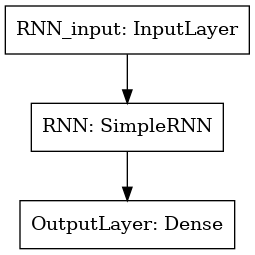

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(RNN10)

In [9]:
start = time()
historyRNN10 = RNN10.fit(X,y,
                         epochs=10,
                         batch_size=batch_size)
print(f"Running time {time()-start}")

2022-12-14 02:41:36.577622: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620464320 exceeds 10% of free system memory.
2022-12-14 02:41:38.714409: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1620464320 exceeds 10% of free system memory.
2022-12-14 02:41:40.122615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3860/3860 [==============================] - 43s 11ms/step - loss: 1.9941 - accuracy: 0.4261
Epoch 2/10
3860/3860 [==============================] - 42s 11ms/step - loss: 1.6105 - accuracy: 0.5276
Epoch 3/10
3860/3860 [==============================] - 42s 11ms/step - loss: 1.4738 - accuracy: 0.5637
Epoch 4/10
3860/3860 [==============================] - 41s 11ms/step - loss: 1.4072 - accuracy: 0.5814
Epoch 5/10
3860/3860 [==============================] - 41s 11ms/step - loss: 1.3673 - accuracy: 0.5917
Epoch 6/10
3860/3860 [==============================] - 41s 11ms/step - loss: 1.3396 - accuracy: 0.5982
Epoch 7/10
3860/3860 [==============================] - 42s 11ms/step - loss: 1.3198 - accuracy: 0.6036
Epoch 8/10
3860/3860 [==============================] - 40s 10ms/step - loss: 1.3051 - accuracy: 0.6070
Epoch 9/10
3860/3860 [==============================] - 40s 10ms/step - loss: 1.2930 - accuracy: 0.6100
Epoch 10/10
3860/3860 [==============================] - 41s 11m

## RNN-10 Generated Text & LM Score

In [25]:
generatedRNN10 = generate_seq(RNN10, mapping_characters, 'she had been', 500)
print(generatedRNN10)

husband and she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been something she had been


In [26]:
Print(f"LM Score RNN10: {lmScore(generatedRNN10)}")

100%|██████████| 458495/458495 [00:00<00:00, 1805349.59B/s]


1.938970992938247

# RNN-100

In [6]:
# Sequence length: 100
sequence_length = 100
number_of_hidden_units = 512
batch_size = 512

characters = sorted(list(set(anna)))
mapping_characters = {char:idx for idx, char in enumerate(characters)}
vocab_size = len(mapping_characters)

sentences = []
following_char = []

for i in range(0, len(anna) - sequence_length):
    sentences.append(anna[i: i+sequence_length])
    following_char.append(anna[i+sequence_length])
    
X = np.zeros((len(sentences), sequence_length, vocab_size), dtype = "bool")
y = np.zeros((len(sentences), vocab_size), dtype = "bool")

for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        X[i, j, mapping_characters[char]] = 1
    y[i, mapping_characters[following_char[i]]] = 1

In [10]:
RNN100 = tf.keras.Sequential([tf.keras.layers.SimpleRNN(number_of_hidden_units, input_shape=(X.shape[1], X.shape[2]),name="RNN"),
                             tf.keras.layers.Dense(vocab_size, activation= tf.keras.activations.softmax, name="OutputLayer")],
                             name="RNN-100")
RNN100.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(1e-3),
                   metrics=["accuracy"])
RNN100.summary()

Model: "RNN-100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN (SimpleRNN)              (None, 512)               304640    
_________________________________________________________________
OutputLayer (Dense)          (None, 82)                42066     
Total params: 346,706
Trainable params: 346,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(RNN100)

In [11]:
start = time()
historyRNN100 = RNN100.fit(X,y,
                         epochs=10,
                         batch_size=batch_size)
print(f"Running time {time()-start}")

2022-12-14 03:12:22.798489: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5185428096 exceeds 10% of free system memory.
2022-12-14 03:12:29.034486: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5185428096 exceeds 10% of free system memory.
2022-12-14 03:12:33.642548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3860/3860 [==============================] - 110s 28ms/step - loss: 1.9059 - accuracy: 0.4519
Epoch 2/10
3860/3860 [==============================] - 107s 28ms/step - loss: 1.5146 - accuracy: 0.5535
Epoch 3/10
3860/3860 [==============================] - 107s 28ms/step - loss: 1.4023 - accuracy: 0.5829
Epoch 4/10
3860/3860 [==============================] - 107s 28ms/step - loss: 1.3476 - accuracy: 0.5965
Epoch 5/10
3860/3860 [==============================] - 109s 28ms/step - loss: 1.3137 - accuracy: 0.6049
Epoch 6/10
3860/3860 [==============================] - 108s 28ms/step - loss: 1.2917 - accuracy: 0.6104
Epoch 7/10
3860/3860 [==============================] - 106s 28ms/step - loss: 1.2752 - accuracy: 0.6142
Epoch 8/10
3860/3860 [==============================] - 107s 28ms/step - loss: 1.2643 - accuracy: 0.6169
Epoch 9/10
3860/3860 [==============================] - 107s 28ms/step - loss: 1.2584 - accuracy: 0.6179
Epoch 10/10
3860/3860 [==============================] 

## RNN-100 Generated Text & LM Score

In [14]:
generatedRNN100 = generate_seq(RNN100, mapping_characters, 'she had been', 500)
print(generatedRNN100)

she had been the same things were at the wind with his wife and showed the whole support of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of the window, and she was a peasants of th


In [17]:
print(f"LM Score RNN100: {lmScore(generatedRNN100)}")


100%|██████████| 478750579/478750579 [00:16<00:00, 28981799.71B/s]

100%|██████████| 656/656 [00:00<00:00, 410911.50B/s]

100%|██████████| 815973/815973 [00:00<00:00, 1907930.90B/s][A

100%|██████████| 458495/458495 [00:00<00:00, 1337775.79B/s][A


LM Score RNN100: 5.604714598721155


# LSTM-100

In [7]:
input_layer = tf.keras.layers.Input(shape=(X.shape[1], X.shape[2]), name="InputLayer")
LSTM_100 = tf.keras.layers.LSTM(number_of_hidden_units, name="LSTM")(input_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation= tf.keras.activations.softmax, name="OutputLayer")(LSTM_100)
modelLSTM_100 = tf.keras.models.Model(input_layer, output_layer, name="RNN10")

modelLSTM_100.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(1e-3),
                   metrics=["accuracy"])

2022-12-14 03:43:59.875433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 03:43:59.876450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 03:43:59.877147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 03:43:59.878058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

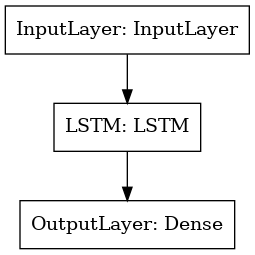

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(modelLSTM_100)

In [9]:
start = time()
historyLSTM100 = modelLSTM_100.fit(X,y,
                         epochs=10,
                         batch_size=batch_size)
print(f"Running time {time()-start}")

2022-12-14 03:44:15.851695: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4861343760 exceeds 10% of free system memory.
2022-12-14 03:44:22.029910: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4861343760 exceeds 10% of free system memory.
2022-12-14 03:44:26.068300: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-14 03:44:28.440890: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3860/3860 [==============================] - 96s 24ms/step - loss: 1.9355 - accuracy: 0.4426
Epoch 2/10
3860/3860 [==============================] - 92s 24ms/step - loss: 1.4519 - accuracy: 0.5679
Epoch 3/10
3860/3860 [==============================] - 92s 24ms/step - loss: 1.2855 - accuracy: 0.6113
Epoch 4/10
3860/3860 [==============================] - 92s 24ms/step - loss: 1.2000 - accuracy: 0.6332
Epoch 5/10
3860/3860 [==============================] - 93s 24ms/step - loss: 1.1472 - accuracy: 0.6468
Epoch 6/10
3860/3860 [==============================] - 93s 24ms/step - loss: 1.1097 - accuracy: 0.6562
Epoch 7/10
3860/3860 [==============================] - 93s 24ms/step - loss: 1.0810 - accuracy: 0.6640
Epoch 8/10
3860/3860 [==============================] - 93s 24ms/step - loss: 1.0572 - accuracy: 0.6701
Epoch 9/10
3860/3860 [==============================] - 93s 24ms/step - loss: 1.0373 - accuracy: 0.6754
Epoch 10/10
3860/3860 [==============================] - 93s 24ms/step - lo

## LSTM-100 Generated Text & LM Score

In [15]:
generatedLSTM100 = generate_seq(modelLSTM_100, mapping_characters, 'she had been', 500)
print(generatedLSTM100)

she had been a man who had been so straight in his own account of the same time with his wife and the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things were standing at the same things we


In [16]:
print(f"LM Score LSTM100: {lmScore(generatedLSTM100)}")

LM Score RNN100: 5.319270521916412


# GRU-100

In [7]:
GRU100 = tf.keras.Sequential([tf.keras.layers.GRU(number_of_hidden_units, input_shape=(X.shape[1], X.shape[2]),name="GRU"),
                             tf.keras.layers.Dense(vocab_size, activation= tf.keras.activations.softmax, name="OutputLayer")],
                             name="GRU-100")
GRU100.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(1e-3),
                   metrics=["accuracy"])
GRU100.summary()

2022-12-14 04:08:52.510424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 04:08:52.511594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 04:08:52.512355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 04:08:52.513416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "GRU-100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, 512)               915456    
_________________________________________________________________
OutputLayer (Dense)          (None, 82)                42066     
Total params: 957,522
Trainable params: 957,522
Non-trainable params: 0
_________________________________________________________________


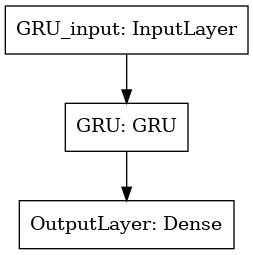

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(GRU100)

In [9]:
start = time()
historyGRU100 = GRU100.fit(X,y,
                         epochs=10,
                         batch_size=batch_size)
print(f"Running time {time()-start}")

2022-12-14 04:08:59.425830: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4861343760 exceeds 10% of free system memory.
2022-12-14 04:09:05.666406: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4861343760 exceeds 10% of free system memory.
2022-12-14 04:09:10.233620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-14 04:09:12.856761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3860/3860 [==============================] - 86s 21ms/step - loss: 1.6817 - accuracy: 0.5080
Epoch 2/10
3860/3860 [==============================] - 81s 21ms/step - loss: 1.2350 - accuracy: 0.6241
Epoch 3/10
3860/3860 [==============================] - 81s 21ms/step - loss: 1.1376 - accuracy: 0.6494
Epoch 4/10
3860/3860 [==============================] - 81s 21ms/step - loss: 1.0858 - accuracy: 0.6629
Epoch 5/10
3860/3860 [==============================] - 81s 21ms/step - loss: 1.0506 - accuracy: 0.6719
Epoch 6/10
3860/3860 [==============================] - 81s 21ms/step - loss: 1.0239 - accuracy: 0.6789
Epoch 7/10
3860/3860 [==============================] - 81s 21ms/step - loss: 1.0027 - accuracy: 0.6849
Epoch 8/10
3860/3860 [==============================] - 80s 21ms/step - loss: 0.9860 - accuracy: 0.6893
Epoch 9/10
3860/3860 [==============================] - 80s 21ms/step - loss: 0.9722 - accuracy: 0.6929
Epoch 10/10
3860/3860 [==============================] - 79s 21ms/step - lo

## GRU-100 Generated Text & LM Score

In [10]:
generatedGRU100 = generate_seq(GRU100, mapping_characters, 'she had been', 500)
print(generatedGRU100)

she had been a child to take him and he was saying. "The peasants were settled in the world was the only oneself, and the princess, and the same straight and high the speck of a servant was the same as when she had been a child to take him and he was saying. "The peasants were settled in the world was the only oneself, and the princess, and the same straight and high the speck of a servant was the same as when she had been a child to take him and he was saying. "The peasants were settled in the world was th


In [11]:
print(f"LM Score GRU100: {lmScore(generatedGRU100)}")

100%|██████████| 458495/458495 [00:00<00:00, 5559508.69B/s]


LM Score GRU100: 18.58916808508328
